In [2]:
# use CEASELESS or seastar Kernel on adrien local laptop

import os
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # => to add in Seastar env
import seastar as ss
#from seastar.utils.tools import dotdict
from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares

import time
from parfor import parfor


# from seastar.gmfs.doppler import *
import pdb

In [109]:
xr.__version__

'0.20.1'

In [2]:
import multiprocessing
from multiprocessing.managers import BaseManager

class MyManager(BaseManager): pass

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
def Manager():
    m = MyManager()
    m.start()
    return m

MyManager.register('dotdict', dotdict)

In [3]:
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
level1 = xr.Dataset(
    data_vars=dict(
            CentralWavenumber=( [],270 ),
            CentralFreq=( [], 13.5 * 10**9 ),
            IncidenceAngleImage=( ['across','along','Antenna'], np.full([5,6,4], 30) ),
            AntennaAzimuthImage=(['across', 'along', 'Antenna'],
                           np.stack((np.full([5, 6], 45),
                                     np.full([5, 6], 90),
                                     np.full([5, 6], 90),
                                     np.full([5, 6], 135)
                                     ), axis=-1
                                    )
                           ),
            Polarization=(['across', 'along','Antenna'],
                          np.stack((np.full([5, 6], 'VV'),
                                    np.full([5, 6], 'VV'),
                                    np.full([5, 6], 'HH'),
                                    np.full([5, 6], 'VV')
                                    ), axis=-1
                                   )
                          ),
#             Sigma0=( ['across','along','Antenna'], np.full([9,11,4], 1.01) ),
#             dsig0=( ['across','along','Antenna'], np.full([9,11,4], 0.05) ),
#             RVL=( ['across','along','Antenna'], np.full([9,11,4], 0.5) ),
#             drvl=( ['across','along','Antenna'], np.full([9,11,4], 0.01) ),
        ),
    coords=dict(
            across=np.arange(0,5),
            along=np.arange(0,6),
            Antenna=['Fore','MidV','MidH','Aft'],
        ),
)
level1 = level1.set_coords([
    'CentralWavenumber',
    'CentralFreq',
    'IncidenceAngleImage',
    'AntennaAzimuthImage',
    'Polarization', 
])


In [5]:
geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['across', 'along'], np.full([5, 6], 10)),
            WindDirection=(['across', 'along'], np.full([5, 6], 150)),
            CurrentVelocity=(['across', 'along'], np.full([5, 6], 1)),
            CurrentDirection=(['across', 'along'], np.full([5, 6], 150)),
        ),
        coords=dict(
            across=np.arange(0, 5),
            along=np.arange(0, 6),
        ),
    )


In [6]:
gmf=dotdict({'nrcs': dotdict({'name': 'nscat4ds'})})
gmf['doppler'] = dotdict({'name': 'mouche12'})

NameError: name 'dotdict' is not defined

In [37]:
gmf_doppler = xr.Dataset()
gmf_doppler['name'] = 'mouche12'
gmf_nrcs = xr.Dataset()
gmf_nrcs['name'] = 'nscat4ds'

In [40]:
level1['Sigma0'] = ss.gmfs.nrcs.compute_nrcs(level1, geo, gmf_nrcs)*1.001

In [41]:
model_rsv_list = [None] * level1.Antenna.size
model_wasv_list = [None] * level1.Antenna.size
for aa, ant in enumerate(level1.Antenna.data):
#     model_wasv_list[aa] = ss.gmfs.doppler.compute_wasv(level1.sel(Antenna=ant), geo, gmf=gmf.doppler.name)
    model_rsv_list[aa] = ss.gmfs.doppler.compute_total_surface_motion(level1.sel(Antenna=ant), geo, gmf=gmf_doppler)
# level1['WASV'] = xr.concat(model_wasv_list, dim='Antenna')*1.001
level1['RSV'] = xr.concat(model_rsv_list, dim='Antenna')*1.001

In [42]:
noise = level1.drop_vars([var for var in level1.data_vars])
# noise = level1.drop_vars(['Sigma0','dsig0','RVL','drvl'])
noise['Sigma0'] = level1.Sigma0*0.05
noise['RSV'] = level1.RSV*0.05

In [43]:
# [geo['U'], geo['V']] = ss.utils.tools.windSpeedDir2UV(geo.WindSpeed, geo.WindDirection)
# [geo['C_U'], geo['C_V']] = ss.utils.tools.currentVelDir2UV(geo.CurrentVelocity, geo.CurrentDirection)

# Test wind_current_retrieval

In [52]:
sL1 = level1.isel(along=slice(0,2), across=slice(0,2))
sN = noise.isel(along=slice(0,2), across=slice(0,2))  # Pass wind_current_retrieval
ambiguity = {'name':'sort_by_cost'} 
ambiguity

{'name': 'sort_by_cost'}

In [44]:
list_L1s0 = list(level1.Sigma0.dims)
list_L1s0.remove('Antenna')
level1_stack = level1.stack(z=tuple(list_L1s0))
noise_stack = noise.stack(z=tuple(list_L1s0))
lmoutmap = [None] * level1_stack.z.size
input_mp = [None] * level1_stack.z.size
for ii in range(level1_stack.z.size):
    input_mp[ii] = dict({
        'level1': level1_stack.isel(z=ii),
        'noise': noise_stack.isel(z=ii),
        'gmf_doppler': gmf_doppler,
        'gmf_nrcs': gmf_nrcs,
    })


# Serial implementation of simple least_squares function

In [40]:
# Example function from SciPy
def fun_rosenbrock(x):
    return np.array([10 * (x[1] - x[0]**2), (1 - x[0])])
import random
i = 1
x0_rosenbrock = np.random.rand(i,2)+2

results_sp = [None] * len(x0_rosenbrock)
t = time.time()
for ii in range (len(results_sp)):
    x0 = x0_rosenbrock[ii,:]
    results_sp[ii] = least_squares(fun_rosenbrock,
                      x0)

print('Serial execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')

results_sp[0]
# if __name__ == '__main__':
#     @parfor(range(10), (3,))
#     def par_task(i, a):
#         return a*i**2
#     print(fun)


Serial execution of 1 completed in 0.0033998489379882812 seconds


 active_mask: array([0., 0.])
        cost: 0.0
         fun: array([0., 0.])
        grad: array([0., 0.])
         jac: array([[-20.00000015,  10.        ],
       [ -1.        ,   0.        ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 4
        njev: 4
  optimality: 0.0
      status: 1
     success: True
           x: array([1., 1.])

In [41]:
t = time.time()
results_mp = [None] * len(x0_rosenbrock)
if __name__ == '__main__':
    @parfor(x0_rosenbrock, nP=4)
    def fun(x0):
        #results_mp = x0_rosenbrock[i] + 1
        #x0 = x0_rosenbrock[i]
        results_mp = least_squares(fun_rosenbrock, x0)
        return results_mp
print('MPI execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')
fun[0]

  0%|          | 0/1 [00:00<?, ?it/s]

MPI execution of 1 completed in 0.03968501091003418 seconds


 active_mask: array([0., 0.])
        cost: 0.0
         fun: array([0., 0.])
        grad: array([0., 0.])
         jac: array([[-20.00000015,  10.        ],
       [ -1.        ,   0.        ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 4
        njev: 4
  optimality: 0.0
      status: 1
     success: True
           x: array([1., 1.])

# Testing geometrically increasing iterations in simplest least_squares case

In [42]:
iteration = [1, 10, 100, 1000, 10000, 100000, 1000000]
sp_time=[]
mp_time=[]
for ii, i in enumerate(iteration):
    x0_rosenbrock = np.random.rand(i,2)+2

    results_sp = [None] * len(x0_rosenbrock)
    t = time.time()
    for ii in range (len(results_sp)):
        x0 = x0_rosenbrock[ii,:]
        results_sp[ii] = least_squares(fun_rosenbrock,
                      x0)
    sp_time.append(time.time()-t)
    print('Serial execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')
    
    t = time.time()
    results_mp = [None] * len(x0_rosenbrock)
    if __name__ == '__main__':
        @parfor(x0_rosenbrock, nP=4)
        def fun(x0):
            results_mp = least_squares(fun_rosenbrock, x0)
            return results_mp
    mp_time.append(time.time()-t)
    print('MPI execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')

Serial execution of 1 completed in 0.010082244873046875 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

MPI execution of 1 completed in 0.03189420700073242 seconds
Serial execution of 10 completed in 0.018950939178466797 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

MPI execution of 10 completed in 14.594474792480469 seconds
Serial execution of 100 completed in 0.08016037940979004 seconds


  0%|          | 0/100 [00:00<?, ?it/s]

MPI execution of 100 completed in 52.78153109550476 seconds
Serial execution of 1000 completed in 0.8260233402252197 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

MPI execution of 1000 completed in 52.08970618247986 seconds
Serial execution of 10000 completed in 8.56774640083313 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

MPI execution of 10000 completed in 67.09905481338501 seconds
Serial execution of 100000 completed in 91.60850977897644 seconds


  0%|          | 0/100000 [00:00<?, ?it/s]

MPI execution of 100000 completed in 99.67087817192078 seconds
Serial execution of 1000000 completed in 1032.4878170490265 seconds


  0%|          | 0/1000000 [00:00<?, ?it/s]

MPI execution of 1000000 completed in 505.5585813522339 seconds


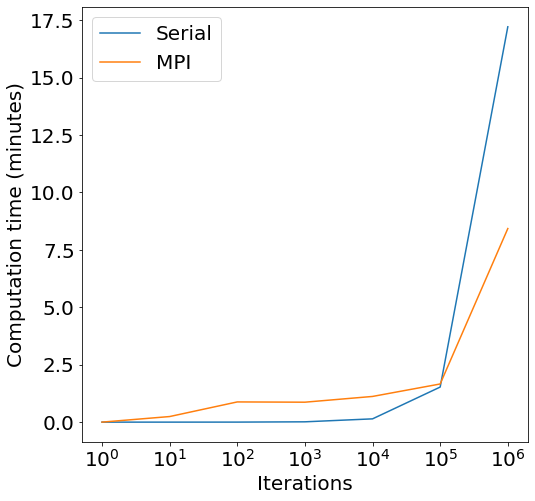

In [60]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plt.plot(iteration, np.array(sp_time)/60, label='Serial')
plt.plot(iteration, np.array(mp_time)/60, label='MPI')
plt.xscale('log')
plt.xticks(iteration)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Computation time (minutes)', fontsize=20)
plt.legend()

In [101]:
i=100
input_mpi = [xr.DataArray(data=np.random.rand(2)+2) for ii in range(i)]
results_sp = [None] * len(input_mpi)
# t = time.time()
# for ii in range (len(results_sp)):
#     x0 = x0_rosenbrock[ii,:]
#     results_sp[ii] = least_squares(fun_rosenbrock,x0)
# sp_time.append(time.time()-t)
# print('Serial execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')

t = time.time()
results_mp = [None] * len(input_mpi)
if __name__ == '__main__':
    @parfor(input_mpi, nP=4)
    def fun(x0):
        x0_i = x0.data
        print(x0_i)
        results_mp = least_squares(fun_rosenbrock, x0_i)
        return results_mp
#mp_time.append(time.time()-t)
print('MPI execution of',len(results_sp),  'completed in', time.time()-t, 'seconds')
fun[0]

  0%|          | 0/100 [00:00<?, ?it/s]

MPI execution of 100 completed in 64.86836361885071 seconds


 active_mask: array([0., 0.])
        cost: 2.465190328815662e-30
         fun: array([2.22044605e-15, 0.00000000e+00])
        grad: array([-4.44089213e-14,  2.22044605e-14])
         jac: array([[-20.00000015,  10.        ],
       [ -1.        ,   0.        ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 3
        njev: 3
  optimality: 4.4408921315878507e-14
      status: 1
     success: True
           x: array([1., 1.])

In [6]:
import multiprocessing
from multiprocessing.managers import BaseManager

class MyManager(BaseManager): pass



class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
def Manager():
    m = MyManager()
    m.start()
    return m

MyManager.register('dotdict', dotdict)

In [53]:
ambiguity

{'name': 'sort_by_cost'}

In [47]:
list_L1s0 = list(level1.Sigma0.dims)
list_L1s0.remove('Antenna')

level1_stack = level1.stack(z=tuple(list_L1s0))
noise_stack = noise.stack(z=tuple(list_L1s0))

# sl1 = element['level1']
# sn = element['noise']

lmoutmap = [None] * level1_stack.z.size
input_mp = [None] * level1_stack.z.size
for ii in range(level1_stack.z.size):
    input_mp[ii] = dict({
        'level1': level1_stack.isel(z=ii),
        'noise': noise_stack.isel(z=ii),
        'gmf_doppler': gmf_doppler,
        'gmf_nrcs': gmf_nrcs,
        'ambiguity': ambiguity
    })

t = time.time()

results_mp = [None] * len(input_mp)
if __name__ == '__main__':
    @parfor(input_mp, nP=4)
    def fun(input_mp):
        level1_pixel = input_mp['level1']
        noise_pixel = input_mp['noise']
        gmf_nrcs = input_mp['gmf_nrcs']
        gmf_doppler = input_mp['gmf_doppler']
        opt = {
        'method': 'trf', # Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
        'xtol':  1e-3, # Tolerance for termination by the change of the independent variables
        'x_scale': [7,7,.5,.5], # Characteristic scale of each variable.
        'bounds': ([-30,-30,-5,-5], [30,30,5,5]),
        } # if modified => change optionLeastSquares2dataset() below
        init = [None] * 4
        init[0] = dotdict({
            'x0': [ 7*np.random.normal(), #u
                   7*np.random.normal(), #v
                   0, # c_u
                   0 ]  # c_v
        })
        lmout = [None] * 4
        lmout_dict = least_squares(fun_residual,
                                   init[0].x0,
                                   args=(level1_pixel, noise_pixel, gmf_doppler, gmf_nrcs),
                                   **opt
                                  )
        lmout[0] = optimizeResults2dataset(lmout_dict, init[0].x0, level1_pixel)

        return lmout
    
    
    

print('MPI execution of',len(fun),  'completed in', time.time()-t, 'seconds')

  0%|          | 0/30 [00:00<?, ?it/s]

MPI execution of 30 completed in 104.23540091514587 seconds


# Full SciRec parallel testbed

In [63]:
list_L1s0 = list(level1.Sigma0.dims)
list_L1s0.remove('Antenna')

level1_stack = level1.stack(z=tuple(list_L1s0))
noise_stack = noise.stack(z=tuple(list_L1s0))

lmoutmap = [None] * level1_stack.z.size
input_mp = [None] * level1_stack.z.size
for ii in range(level1_stack.z.size):
    input_mp[ii] = dict({
        'level1': level1_stack.isel(z=ii),
        'noise': noise_stack.isel(z=ii),
        'gmf_doppler': gmf_doppler,
        'gmf_nrcs': gmf_nrcs,
        'ambiguity': ambiguity
    })


if __name__ == '__main__':
    @parfor(input_mp, nP=4)
    def fun(input_mp):
        level1_pixel = input_mp['level1']
        noise_pixel = input_mp['noise']
        gmf_nrcs = input_mp['gmf_nrcs']
        gmf_doppler = input_mp['gmf_doppler']
        ambiguity = input_mp['ambiguity']
        l2 = wind_current_retrieval(level1_pixel, noise_pixel, gmf_doppler, gmf_nrcs, ambiguity)
        return l2

  0%|          | 0/30 [00:00<?, ?it/s]

In [106]:
pdb.set_trace()
l2 = wind_current_retrieval(level1, noise, gmf_doppler, gmf_nrcs, ambiguity)

--Return--
None
> c:\users\davidmccann\appdata\local\temp\ipykernel_21832\1053987086.py(1)<cell line: 1>()

ipdb> c


  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: cannot unstack dimensions that do not have a MultiIndex: ['z']

In [110]:
pdb.pm()

> c:\users\davidmccann\anaconda3\lib\site-packages\xarray\core\dataset.py(4173)unstack()
   4171             ]
   4172             if non_multi_dims:
-> 4173                 raise ValueError(
   4174                     "cannot unstack dimensions that do not "
   4175                     f"have a MultiIndex: {non_multi_dims}"

ipdb> u
> c:\users\davidmccann\appdata\local\temp\ipykernel_21832\221513557.py(43)run_find_minima()

ipdb> l
     38         lmmap = xr.concat(lmoutmap, dim='z')
     39         coords_dict = {i: level1.Sigma0[i] for i in list_L1s0}
     40         lmmap = lmmap.assign_coords(coords_dict)
     41         lmmap.set_index({dim:dim for dim in list_L1s0})
     42 #         lmmap = lmmap.set_index(z=list_L1s0)
---> 43         sol = lmmap.unstack(dim='z')
     44     elif len(list_L1s0) == 1:  # 1d
     45         length = level1[list_L1s0[0]].size
     46         lmoutmap = [None] * length
     47         for ii in range(length):
     48             sl1 = level1.isel(

In [104]:
a = xr.Dataset()

list_L1s0 = list(level1.Sigma0.dims)
list_L1s0.remove('Antenna')
coords_dict = {i: level1.Sigma0[i] for i in list_L1s0}
a = a.assign_coords(coords_dict)
#for i, dim in enumerate(list_L1s0):
a.set_index({dim:dim for dim in list_L1s0}) 
a

<xarray.Dataset>
Dimensions:            (across: 5, along: 6)
Coordinates:
    CentralWavenumber  int32 270
    CentralFreq        float64 1.35e+10
  * across             (across) int32 0 1 2 3 4
  * along              (along) int32 0 1 2 3 4 5
Data variables:
    *empty*

# Scirec functions

In [105]:
import numpy as np
import xarray as xr
from scipy.optimize import least_squares
import seastar
from seastar.utils.tools import dotdict, da2py


def wind_current_retrieval(level1, noise, gmf_doppler, gmf_nrcs, ambiguity):
    lmout = run_find_minima(level1, noise, gmf_doppler, gmf_nrcs)
    sol = ss.retrieval.ambiguity_removal.solve_ambiguity(lmout, ambiguity)
    level2 = sol2level2(sol)
    return level2

def run_find_minima(level1, noise, gmf_doppler, gmf_nrcs):
    list_L1s0 = list(level1.Sigma0.dims)
    list_L1s0.remove('Antenna')
    if len(list_L1s0) > 1:  # 2d or more
        level1_stack = level1.stack(z=tuple(list_L1s0))
        noise_stack = noise.stack(z=tuple(list_L1s0))
#         lmoutmap = [None] * level1_stack.z.size
        input_mp = [None] * level1_stack.z.size
        for ii in range(level1_stack.z.size):
            input_mp[ii] = dict({
                'level1': level1_stack.isel(z=ii),
                'noise': noise_stack.isel(z=ii),
                'gmf_doppler': gmf_doppler,
                'gmf_nrcs': gmf_nrcs,
            })
        if __name__ == '__main__':
            @parfor(input_mp, nP=4)
            def lmoutmap(input_mp):
                sl1 = input_mp['level1']
                sn = input_mp['noise']
                gmf_nrcs = input_mp['gmf_nrcs']
                gmf_doppler = input_mp['gmf_doppler']
                lmout = find_minima(sl1, sn, gmf_doppler, gmf_nrcs)
                return lmout
        lmmap = xr.concat(lmoutmap, dim='z')
        coords_dict = {i: level1.Sigma0[i] for i in list_L1s0}
        lmmap = lmmap.assign_coords(coords_dict)
        lmmap.set_index({dim:dim for dim in list_L1s0}) 
#         lmmap = lmmap.set_index(z=list_L1s0)
        sol = lmmap.unstack(dim='z')
    elif len(list_L1s0) == 1:  # 1d
        length = level1[list_L1s0[0]].size
        lmoutmap = [None] * length
        for ii in range(length):
            sl1 = level1.isel({list_L1s0[0]: ii})
            sn = noise.isel({list_L1s0[0]: ii})
            lmout = find_minima(sl1, sn, gmf_doppler, gmf_nrcs)
            lmout = lmout.sortby('cost')
            # lmout = ambiguity_removal.solve_ambiguity(lmout, ambiguity)
            lmoutmap[ii] = lmout
        sol = xr.concat(lmoutmap, dim=list_L1s0[0])
    else:  # single pixel
        sol = find_minima(level1, noise, gmf_doppler, gmf_nrcs)
        sol = sol.sortby('cost')
        # sol = ambiguity_removal.solve_ambiguity(lmout, ambiguity)
    return sol

def sol2level2(sol):
    level2 = sol.drop_vars(sol.data_vars)
    level2['x'] = sol.x  # .isel(Ambiguities=0)
    level2['cost'] = sol.cost
    level2['CurrentU'] = level2.x.sel(x_variables='c_u')
    level2['CurrentV'] = level2.x.sel(x_variables='c_v')
    level2['WindU'] = level2.x.sel(x_variables='u')
    level2['WindV'] = level2.x.sel(x_variables='v')

    [level2['CurrentVelocity'], cdir] = \
        ss.utils.tools.currentUV2VelDir(
            level2['CurrentU'],
            level2['CurrentV']
        )
    level2['CurrentDirection'] = (level2.CurrentVelocity.dims, cdir)

    [level2['WindSpeed'], wdir] = \
        ss.utils.tools.windUV2SpeedDir(
            level2['WindU'],
            level2['WindV']
        )
    level2['WindDirection'] = (level2.WindSpeed.dims, wdir)
    return level2


def fun_residual(variables, level1, noise, gmf_doppler, gmf_nrcs):
    # Initialisation
    u = da2py(variables[0])
    v = da2py(variables[1])
    c_u = da2py(variables[2])
    c_v = da2py(variables[3])

    #TODO if len(variables)==2; inversion of wind only and c_u=0 cf Matalb and find_simple_minimum
    vis_u = u - c_u
    vis_v = v - c_v

    [vis_wspd, vis_wdir] = seastar.utils.tools.windUV2SpeedDir(vis_u, vis_v)
    [c_vel, c_dir] = seastar.utils.tools.currentUV2VelDir(c_u, c_v)

    model = level1.drop_vars([var for var in level1.data_vars]) # to keep only the coordinates

    geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(level1.isel(Antenna=0).IncidenceAngleImage.dims, vis_wspd),
            WindDirection=(level1.isel(Antenna=0).IncidenceAngleImage.dims, vis_wdir),
            CurrentVelocity=(level1.isel(Antenna=0).IncidenceAngleImage.dims, c_vel),
            CurrentDirection=(level1.isel(Antenna=0).IncidenceAngleImage.dims, c_dir),
        ),
    )
    # propagate relevant Level1 coords to geo
    for dim in level1.isel(Antenna=0).IncidenceAngleImage.dims:
        geo.coords[dim] = level1.isel(Antenna=0).coords[dim]
    if 'Antenna' in geo.coords:
        geo = geo.drop_vars('Antenna')

    # paragraph below to be changed in future without the loop for Antenna
    model_rsv_list = [None] * level1.Antenna.size
    for aa, ant in enumerate(level1.Antenna.data):
        #print(aa, ant)
        l1 = level1.sel(Antenna=ant)
        #gmf_name = gmf['doppler']['name']
#         gmf_name='mouche12'
#         model_rsv_list[aa] = seastar.gmfs.doppler.compute_total_surface_motion(l1, geo, gmf_name)
        model_rsv_list[aa] = seastar.gmfs.doppler.compute_total_surface_motion(level1.sel(Antenna=ant), geo, gmf=gmf_doppler.name)
    model['RSV'] = xr.concat(model_rsv_list, dim='Antenna')
    # in future it should be: model['RSV'] = seastar.gmfs.doppler.compute_total_surface_motion(level1, geo, gmf=gmf.doppler) without the loop on antennas
#     a = xr.Dataset()
#     a['name'] = 'nscat4ds'
    model['Sigma0'] = seastar.gmfs.nrcs.compute_nrcs(level1, geo, gmf=gmf_nrcs)
    
    res = ( level1 - model ) / noise # DataSet with RSV and Sigma0 fields

    sigma0_axis_num = level1.Sigma0.get_axis_num('Antenna')
    rsv_axis_num = level1.RSV.get_axis_num('Antenna')
    if sigma0_axis_num == rsv_axis_num:
        concat_axis = sigma0_axis_num
    else:
        raise Exception('Different axis in Antenna for Sigma0 and RSV')

    out = np.concatenate(
        (res.Sigma0.data, res.RSV.data),
        axis=concat_axis,
    )

    return np.where(np.isfinite(out), out, 0)

def find_minima(level1_pixel, noise_pixel, gmf_doppler, gmf_nrcs):

    opt = {
        'method': 'trf', # Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
        'xtol':  1e-3, # Tolerance for termination by the change of the independent variables
        'x_scale': [7,7,.5,.5], # Characteristic scale of each variable.
        'bounds': ([-30,-30,-5,-5], [30,30,5,5]),
    } # if modified => change optionLeastSquares2dataset() below

    init = [None] * 4
    init[0] = dotdict({
        'x0': [ 7*np.random.normal(), #u
                7*np.random.normal(), #v
                0, # c_u
                0 ]  # c_v
    })

    lmout = [None] * 4
    # find the first minimum with begin current = 0
    lmout_dict = least_squares(
        fun_residual,
        init[0].x0,
        args=(level1_pixel, noise_pixel, gmf_doppler, gmf_nrcs),
        **opt
    )
    lmout[0] = optimizeResults2dataset(lmout_dict, init[0].x0, level1_pixel)

    # find the 3 ambiguities and run the minimisation to find the 3 minima
    init[1:3] = find_initial_values(lmout[0].x, level1_pixel, gmf_doppler, gmf_nrcs)
    for ii in [1,2,3]:
        lmout_dict = least_squares(
            fun_residual,
            init[ii].x0,
            args=(level1_pixel, noise_pixel, gmf_doppler, gmf_nrcs),
            **opt
        )
        lmout[ii] = optimizeResults2dataset(lmout_dict, init[ii].x0, level1_pixel)

    dslmout = xr.concat(lmout, dim='Ambiguities')
    dslmout = optionLeastSquares2dataset(opt, dslmout)
    dslmout = dslmout.assign_coords(level1_pixel.coords)

    return dslmout

def x2uvcucv(x):
    out = dotdict({
        'u': x[0],
        'v': x[1],
        'c_u': x[2],
        'c_v': x[3]
    })
    return out

def uvcucv2x(mydict):
    x = np.array([
        mydict['u'],
        mydict['v'],
        mydict['c_u'],
        mydict['c_v'],
    ])
    return x

def optionLeastSquares2dataset(opt, dslmout):
    dslmout['method'] = opt['method']
    dslmout['xtol'] = opt['xtol']
    dslmout['x_scale'] = (('x_variables'), opt['x_scale'])
    dslmout['bounds'] = (('extrema','x_variables'), np.asarray(opt['bounds']))

    # description from
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
    dslmout.method.attrs['description'] = \
        'Algorithm to perform minimization. ' \
        '‘trf’ : Trust Region Reflective algorithm, particularly suitable for ' \
        'large sparse problems with bounds. Generally robust method.' \
        '‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use ' \
        'case is small problems with bounds. Not recommended for problems with ' \
        'rank-deficient Jacobian.' \
        '‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. ' \
        'Doesn’t handle bounds and sparse Jacobians. Usually the most efficient ' \
        'method for small unconstrained problems'
    dslmout.xtol.attrs['description'] = \
        'Tolerance for termination by the change of the independent variables.' \
        ' Default is 1e-8. The exact condition depends on the method used:' \
        'For ‘trf’ and ‘dogbox’ : norm(dx) < xtol * (xtol + norm(x)).' \
        'For ‘lm’ : Delta < xtol * norm(xs), where Delta is a trust-region radius ' \
        'and xs is the value of x scaled according to x_scale parameter (see below).' \
        'If None and ‘method’ is not ‘lm’, the termination by this condition is disabled.' \
        ' If ‘method’ is ‘lm’, this tolerance must be higher than machine epsilon'
    dslmout.x_scale.attrs['description'] = \
        'Characteristic scale of each variable. Setting x_scale is equivalent to ' \
        'reformulating the problem in scaled variables xs = x / x_scale. An alternative ' \
        'view is that the size of a trust region along jth dimension is proportional ' \
        'to x_scale[j]. Improved convergence may be achieved by setting x_scale such that' \
        ' a step of a given size along any of the scaled variables has a similar effect on' \
        ' the cost function. If set to ‘jac’, the scale is iteratively updated using the ' \
        'inverse norms of the columns of the Jacobian matrix (as described in [JJMore]).'
    dslmout.bounds.attrs['description'] = \
        'Lower and upper bounds on independent variables. Defaults to no bounds. ' \
        'Each array must match the size of x0 or be a scalar, in the latter case a bound ' \
        'will be the same for all variables. ' \
        'Use np.inf with an appropriate sign to disable bounds on all or some variables.'

    return dslmout

def optimizeResults2dataset(lmout, x0, level1):
    d = dict()
    d['x_variables'] = {"dims": "x_variables", "data": np.array(['u', 'v', 'c_u', 'c_v'])}
    d['Observables'] = {"dims": "Observables", "data": np.array(['sigma0', 'RSV'])}
    # d['fun_variables'] = {"dims": "fun_variables", "data": range(8)}
    d['Antenna'] = {"dims": "Antenna", "data": level1.Antenna.data}
    d['fun_variables'] = {"dims": ("Observables", "Antenna"), "data": np.array([range(0,4), range(4,8)])}

    # import variables with dimension
    dims_variables = {
        'x': 'x_variables',
        'active_mask': 'x_variables',
        'grad': 'x_variables',
        'fun': ('Observables', 'Antenna'),
        'jac': ('fun_variables', 'x_variables'),
    }
    for var in dims_variables.keys():
        if var in ['fun','jac']:
            d[var] = {
                "dims": dims_variables[var],
                "data": lmout[var].reshape(
                    d[dims_variables[var][0]]['data'].size,
                    d[dims_variables[var][1]]['data'].size
                )
            }
        else:
            d[var] = {"dims": (dims_variables[var]), "data": lmout[var]}

    ds = xr.Dataset.from_dict(d)

    # add x0
    ds['x0'] = (('x_variables'), x0)
    # import variables without dimension
    nodims_variables = ['cost', 'optimality', 'nfev', 'njev', 'status', 'message', 'success']
    for var in nodims_variables:
        ds[var] = lmout[var]
    # description from
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
    ds.x0.attrs['description'] = \
        'Initial guess on independent variables'
    ds.x.attrs['description'] = \
        'Solution found'
    ds.cost.attrs['description'] = \
        'Value of the cost function at the solution'
    ds.fun.attrs['description'] = \
        'Vector of residuals at the solution'
    ds.jac.attrs['description'] = \
        'Modified Jacobian matrix at the solution, in the sense that J^T J is a Gauss-' \
        'Newton approximation of the Hessian of the cost function. The type is the same ' \
        'as the one used by the algorithm'
    ds.grad.attrs['description'] = \
        'Gradient of the cost function at the solution'
    ds.optimality.attrs['description'] = \
        'First-order optimality measure. In unconstrained problems, it is always the ' \
        'uniform norm of the gradient. In constrained problems, it is the quantity ' \
        'which was compared with gtol during iterations'
    ds.active_mask.attrs['description'] = \
        'Each component shows whether a corresponding constraint is active ' \
        '(that is, whether a variable is at the bound):' \
        '0 : a constraint is not active.; -1 : a lower bound is active.; 1 : an upper bound is active.' \
        'Might be somewhat arbitrary for ‘trf’ method as it generates a sequence of ' \
        'strictly feasible iterates and active_mask is determined within a tolerance threshold. '
    ds.nfev.attrs['description'] = \
        'Number of function evaluations done. Methods ‘trf’ and ‘dogbox’ do not ' \
        'count function calls for numerical Jacobian approximation, as opposed to ‘lm’ method.'
    ds.njev.attrs['description'] = \
        'Number of Jacobian evaluations done. If numerical Jacobian approximation ' \
        'is used in ‘lm’ method, it is set to None'
    ds.status.attrs['description'] = \
        'The reason for algorithm termination: ' \
        '-1 : improper input parameters status returned from MINPACK.' \
        '0 : the maximum number of function evaluations is exceeded.' \
        '1 : gtol termination condition is satisfied.' \
        '2 : ftol termination condition is satisfied.' \
        '3 : xtol termination condition is satisfied.' \
        '4 : Both ftol and xtol termination conditions are satisfied.'
    ds.message.attrs['description'] = \
        'Verbal description of the termination reason'
    ds.success.attrs['description'] = \
        'True if one of the convergence criteria is satisfied (status > 0)'

    return ds

def find_initial_values(sol1st_x, level1_inst, gmf_doppler, gmf_nrcs):
    WS = np.array([5,10])
    dte_coef = 0.03 # to update with matlab code below diff(WASV)/diff(WS)
    def smooth(x):
        if np.abs(x) < 0.5: #3:
            return(x/3)
        else:
            return(x)
    # dte = lambda x: smooth(x) * np.sign(x) * dte_coef * (np.abs(x) - WS[0])
    dte = lambda x: -np.sign(x) * smooth ( 0.5 + dte_coef * (np.abs(x) - WS[0]) )
    sol = x2uvcucv(sol1st_x)
    sol = seastar.utils.tools.windCurrentUV2all(sol)
    init_list = [None] * 3
    meas_cur = dotdict({
        'c_u': ( dte(sol['vis_u']) + sol['c_u'] ),
        'c_v': ( dte(sol['vis_v']) + sol['c_v'] ),
    })
    for ii in range(len(init_list)):
        init = dotdict({})
        init['vis_wspd'] = sol['vis_wspd']
        init['vis_wdir'] = np.mod( sol['vis_wdir'] + (ii+1)*90, 360)
        init['vis_u'], init['vis_v'] = \
            seastar.utils.tools.windSpeedDir2UV(
                init['vis_wspd'], init['vis_wdir']
            )
        init['c_u'] = meas_cur['c_u'] - dte(init['vis_u'])
        init['c_v'] = meas_cur['c_v'] - dte(init['vis_v'])
        init['u'] = init['vis_u'] + init['c_u']
        init['v'] = init['vis_v'] + init['c_v']
        init_list[ii] = \
            dotdict({
                'x0': uvcucv2x(init)
            })
        # test boundary # TODO properly from least_square/opt in future # with raise Exception
        # print(init_list[ii])
        if ((init_list[ii]['x0'] - np.array([-30,-30,-5,-5])) < 0).any():
            print('below boundary')
            print(init_list[ii], init)
        if ((init_list[ii]['x0'] - np.array([30,30,5,5])) > 0).any():
            print('above boundary')
            print(init_list[ii], init)

    print("To Be Done find_initial_value")

    return init_list
